# Workflow

- Title Page and authors
- Workflow
- Introduction
- Naive Bayes Theory
- Problem in assumption
- Solution: Using KDE as likelihood
- KDE Theory
- Bandwidth Selection: why important
- Asymptotic theorems
- Used Bandwidth Selection Methods
- Results
  - Simulated Data
  - Real world data
- Conclusion

# Library Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer as breast_cancer
from sklearn.datasets import load_iris as iris
from sklearn.datasets import load_wine as wine

datasets = {'breast_cancer': breast_cancer, 'iris': iris, 'wine': wine}

from FlexibleNB import FlexibleNB

In [2]:
def result_with_data(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    methods = ['scott', 'silverman', 'cv_ml', 'cv_ls']
    results = pd.DataFrame(
        columns=['Train Accuracy', 'Test Accuracy'], 
        index=['gaussian'] + methods)
    model = GaussianNB()
    model.fit(X_train, y_train)
    results.loc['gaussian', 'Train Accuracy'] = model.score(X_train, y_train)
    results.loc['gaussian', 'Test Accuracy'] = model.score(X_test, y_test)
    for method in methods:
        model = FlexibleNB(method, 'c'*X.shape[1])
        model.fit(X_train, y_train)
        results.loc[method, 'Train Accuracy'] = model.score(X_train, y_train)
        results.loc[method, 'Test Accuracy'] = model.score(X_test, y_test)
    return results

# Simulation

In [3]:
def simulate_normal(sim_num, progress_bar=None):
    # C = [i for i in range(5)]
    try:
        sample_size = [100,110,95,101,99]
        cov = np.identity(6)
        X = []
        y = []
        for i in range(len(sample_size)):
            mean = [i]*6
            sample = list(np.random.multivariate_normal(mean, cov, sample_size[i]))
            X += sample
            y += [i]*sample_size[i]
        X = np.array(X)
        y = np.array(y)
        # print("Normal Population")
        result = result_with_data(X, y, 0.25)
        result.to_csv(f"./results/normal-{sim_num:04}.csv")
        if progress_bar:
            progress_bar.update()
    except Exception as e:
        print(e)


def simulate_non_normal(sim_num, progress_bar):
    # C = [i for i in range(5)]
    sample_size = [100,110,95,101,99]
    X = []
    y = []
    for i in range(len(sample_size)):
        sample = list(np.random.laplace(loc = i, scale = 1, size = (sample_size[i],6)))
        X += sample
        y += [i]*sample_size[i]
    X = np.array(X)
    y = np.array(y)
    # print("Non-Normal Population")
    result = result_with_data(X, y, 0.25)
    result.to_csv(f"./results/non-normal-{sim_num:04}.csv")
    if progress_bar:
            progress_bar.update()

In [4]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

with tqdm(total=1000) as progress_bar:
    with ThreadPoolExecutor() as executor:
        executor.map(lambda i: simulate_normal(i, progress_bar), range(1, 1001))

In [5]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

with tqdm(total=50) as progress_bar:
    with ThreadPoolExecutor() as executor:
        executor.map(lambda i: simulate_non_normal(i, progress_bar), range(101, 151))

100%|██████████| 50/50 [51:17<00:00, 61.55s/it]  


In [10]:
normal_result = np.zeros((5, 2, 150))
for i in range(1, 151):
    df = pd.read_csv(f"./results/normal-{i:04}.csv", index_col=0)
    df = df.to_numpy()
    normal_result[:, :, i-1] = df

non_normal_result = np.zeros((5, 2, 150))
for i in range(1, 151):
    df = pd.read_csv(f"./results/non-normal-{i:04}.csv", index_col=0)
    df = df.to_numpy()
    non_normal_result[:, :, i-1] = df

In [11]:
normal_result.mean(axis=-1), non_normal_result.mean(axis=-1)

(array([[0.83458554, 0.80992126],
        [0.99123457, 0.74892388],
        [0.99564374, 0.7416273 ],
        [0.97114638, 0.76587927],
        [0.98326279, 0.72734908]]),
 array([[0.73479718, 0.68834646],
        [0.97151675, 0.66671916],
        [0.98162257, 0.6616273 ],
        [0.93737213, 0.67191601],
        [0.98740741, 0.61475066]]))

# Toy Datasets

In [25]:
for name, load_data in datasets.items():
    print(name)
    X, y = load_data(return_X_y=True)
    print(result_with_data(X, y, 0.25))

breast_cancer
                 Train Accuracy Test Accuracy
gaussian               0.934272       0.93007
scott                  0.995305      0.937063
silverman              0.997653      0.951049
normal_reference       0.946009      0.923077
cv_ml                  0.976526      0.944056
cv_ls                       1.0       0.41958
iris
                 Train Accuracy Test Accuracy
gaussian               0.946429           1.0
scott                       1.0           1.0
silverman                   1.0           1.0
normal_reference       0.982143      0.973684
cv_ml                  0.991071      0.973684
cv_ls                       1.0      0.789474
wine
                 Train Accuracy Test Accuracy
gaussian               0.992481      0.933333
scott                       1.0           1.0
silverman                   1.0           1.0
normal_reference            1.0           1.0
cv_ml                       1.0      0.977778
cv_ls                  0.984962      0.644444


# Kernel GIF

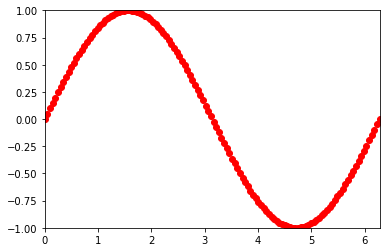

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
ani.save('gif.mp4')

 36%|███▌      | 361/1000 [04:53<08:39,  1.23it/s]


KeyboardInterrupt: 

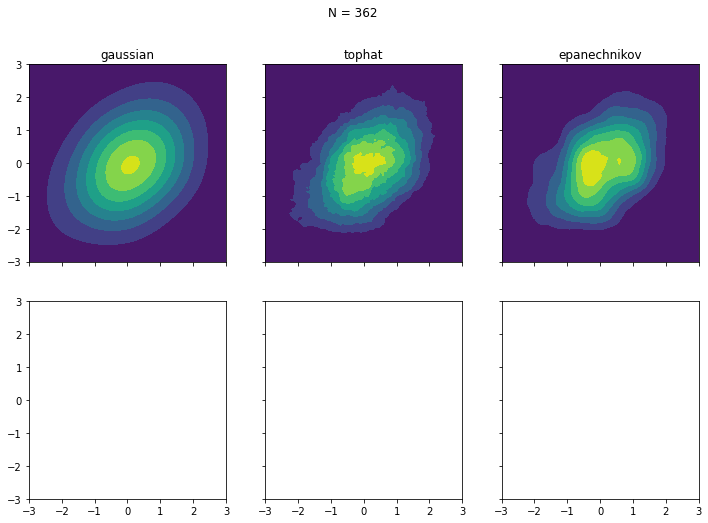

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from itertools import product
from tqdm import trange

%matplotlib inline

data = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, 0.5], [0.5, 1]]), 1000)

X1 = X2 = np.linspace(-3, 3, 100)
points = np.array(list(product(X1, X2)))

X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

kernels = [['gaussian', 'tophat', 'epanechnikov'], ['exponential', 'linear', 'cosine']]


for i in trange(1, len(data) + 1):
    sample = data[:i, :]

    fig, axs = plt.subplots(2, 3, sharex='all', sharey='all')
    fig.set_size_inches(12, 8)
    fig.suptitle(f"N = {i}")

    for row in range(2):
        for col in range(3):

            kde = KernelDensity(kernel=kernels[row][col], bandwidth=0.75)
            kde.fit(sample)
            density = np.exp(kde.score_samples(points))

            axs[row, col].contourf(X, Y, density.reshape(100, 100))
            axs[row, col].set_title(kernels[row][col])

    fig.savefig(f'images/frame-{i:04}.jpg')
    plt.close()